# Monet Style Transfer — CycleGAN⚡PyTorch Lightning

_Note: Cleared the output of some cells to reduce file size. The full output can be viewed [here](https://www.kaggle.com/code/chongzhenjie/monet-style-transfer-cyclegan-pytorch-lightning)._

This notebook aims to implement CycleGAN, with the model architecture being adapted from the [tutorial](https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook) available. We attempt to convert the code to PyTorch Lightning here. A useful reference for PyTorch Lightning can be found in this [documentation](https://pytorch-lightning.readthedocs.io/en/stable/notebooks/lightning_examples/basic-gan.html). More details regarding CycleGAN can be found in the original [paper](https://arxiv.org/abs/1703.10593) and [code](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix).

In [1]:
import glob
import os
import shutil

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.io import read_image
from torchvision.utils import make_grid, save_image

---

# 1. Preprocessing Data

In [2]:
def show_img(img_tensor, nrow=5, title=""):
    img_tensor = img_tensor.detach().cpu()*0.5 + 0.5
    img_grid = make_grid(img_tensor, nrow=nrow).permute(1, 2, 0)
    plt.figure(figsize=(18, 8))
    plt.imshow(img_grid)
    plt.axis("off")
    plt.title(title)
    plt.show()

### Augmenting the images.

Before loading the datasets, we define `CustomTransform` for image augmentation. This improves learning by introducing more variety in the images during training instead of learning from the same set of images in every epoch, especially when we only have 300 Monet paintings. We look at some basic image transformations available in `torchvision.transforms`:
* Scaling the images larger using `Resize` and then randomly cropping to the original size of 256 with `RandomCrop` to obtain slightly different images.
* Randomly rotating the images using `CustomRotation`.
* Randomly flipping the images using `RandomHorizontalFlip` and `RandomVerticalFlip`.

Other possible transformations can be found [here](https://pytorch.org/vision/stable/transforms.html). These transformations are only needed during model training/fitting, and we specify this using the `stage` argument. Finally, the images are scaled down for better convergence.

In [3]:
class CustomRotation(object):
    def __call__(self, x):
        angle = np.random.choice([0., 90, 180, 270])
        return transforms.functional.rotate(x, angle)

class CustomTransform(object):
    def __init__(self, load_dim=286, target_dim=256):
        self.transform = transforms.Compose([
            transforms.Resize((load_dim, load_dim)),
            transforms.RandomCrop((target_dim, target_dim)),
            CustomRotation(),
            transforms.RandomHorizontalFlip(0.5),
            transforms.RandomVerticalFlip(0.5),
        ])
        
    def __call__(self, img, stage="fit"):
        if stage == "fit":
            img = self.transform(img)
        return img/127.5 - 1

### Storing the datasets.

To load and store the datasets, we define a custom `torch.utils.data.Dataset` class involving three main methods: 
* `__init__` to initialize the class.
* `__len__` to retrieve the size of the dataset.
* `__getitem__` to get the i-th sample of images after performing the transformations described above. 

For model training, because we have less number of images for Monet paintings than for photos, we define an additional method `shuffle` to shuffle the indices of the photos and retrieve the first 300 indices. These indices are then used in `__getitem__` to allow all photos to be sampled.

Similarly, we define the `stage` argument to differentiate between the training dataset and prediction dataset. The training dataset contains both the Monet paintings and photos. In contrast, the prediction dataset only has photos since we are trying to generate Monet-style images in this notebook.

In [4]:
class CustomDataset(Dataset):
    def __init__(self, monet_filenames, photo_filenames, transform, stage):
        self.photo_filenames = photo_filenames
        self.transform = transform
        self.stage = stage
        if stage == "fit":
            self.monet_filenames = monet_filenames
            self.check = len(monet_filenames)>len(photo_filenames)
            self.shuffle()
            
    def shuffle(self):
        if self.check:
            self.indices = torch.randperm(len(self.monet_filenames))[:len(self.photo_filenames)]
            
        else:
            self.indices = torch.randperm(len(self.photo_filenames))[:len(self.monet_filenames)]
        
    def __len__(self):
        if self.stage == "fit":
            return min(
                len(self.monet_filenames), len(self.photo_filenames),
            )
    
        elif self.stage == "predict":
            return len(self.photo_filenames)
    
    def __getitem__(self, idx):
        if self.stage == "fit":
            monet_idx = self.indices[idx] if self.check else idx
            photo_idx = idx if self.check else self.indices[idx]
            monet_name = self.monet_filenames[monet_idx]
            photo_name = self.photo_filenames[photo_idx]
            monet = read_image(monet_name)
            photo = read_image(photo_name)
            if idx == len(self)-1:
                self.shuffle()
            return self.transform(monet), self.transform(photo)
    
        elif self.stage == "predict":
            photo_name = self.photo_filenames[idx]
            photo = read_image(photo_name)
            return self.transform(photo, stage=self.stage)

### Iterating through the datasets.

To prepare the datasets for training and prediction, we load them into `torch.utils.data.DataLoader` which can then iterate through the datasets as needed. To organize all the steps described above for processing data, we define a datamodule using `pl.LightningDataModule`. A datamodule involves many methods, but we are mainly concerned with:
* `setup` to create the datasets and apply the corresponding transformations defined above.
* `train_dataloader` to generate the dataloader for the training dataset.
* `predict_dataloader` to generate the dataloader for the prediction dataset.

Other possible methods can be found [here](https://pytorch-lightning.readthedocs.io/en/stable/data/datamodule.html). We define the following parameters:
* `MONET_DIR` and `PHOTO_DIR` — the directories where the Monet paintings and photos are loaded from respectively.
* `BATCH_SIZE` — the number of samples in each training/prediction batch.

In [5]:
MONET_DIR = "/kaggle/input/gan-getting-started/monet_jpg/*.jpg"
PHOTO_DIR = "/kaggle/input/gan-getting-started/photo_jpg/*.jpg"
BATCH_SIZE = 1
transform = CustomTransform()

In [6]:
class CustomDataModule(pl.LightningDataModule):
    def __init__(
        self, 
        monet_dir=MONET_DIR,
        photo_dir=PHOTO_DIR,
        batch_size=BATCH_SIZE,
        transform=transform,
    ):
        super().__init__()
        self.monet_filenames = sorted(glob.glob(monet_dir))
        self.photo_filenames = sorted(glob.glob(photo_dir))
        self.batch_size = batch_size
        self.transform = transform
        
    def setup(self, stage):
        if stage == "fit":
            self.train = CustomDataset(
                monet_filenames=self.monet_filenames,
                photo_filenames=self.photo_filenames,
                transform=self.transform,
                stage=stage,
            )
        
        elif stage == "predict":
            self.predict = CustomDataset(
                monet_filenames=self.monet_filenames,
                photo_filenames=self.photo_filenames,
                transform=self.transform,
                stage=stage,
            )
            
    def train_dataloader(self):
        return DataLoader(
            self.train, 
            batch_size=self.batch_size,
            shuffle=True,
        )
    
    def predict_dataloader(self):
        return DataLoader(
            self.predict, 
            batch_size=self.batch_size,
            shuffle=False,
        )

We check that the datamodule defined is working as intended by visualizing samples of the images below.

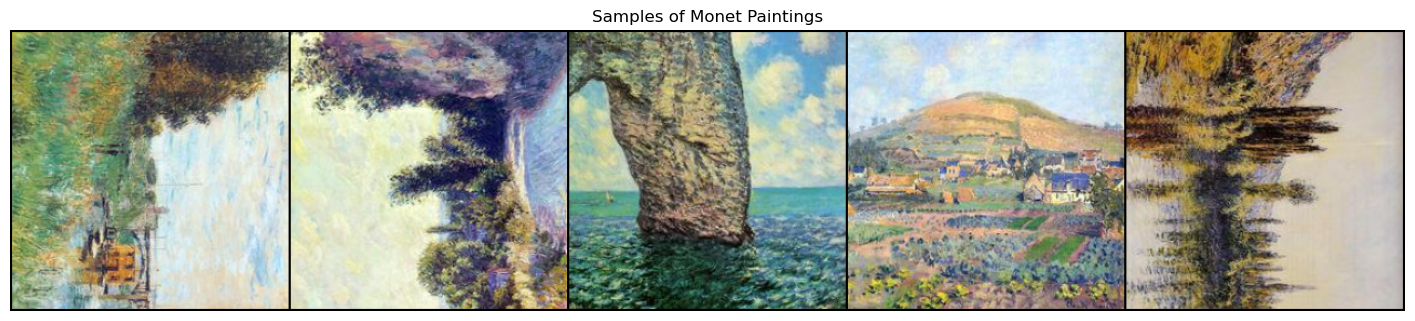

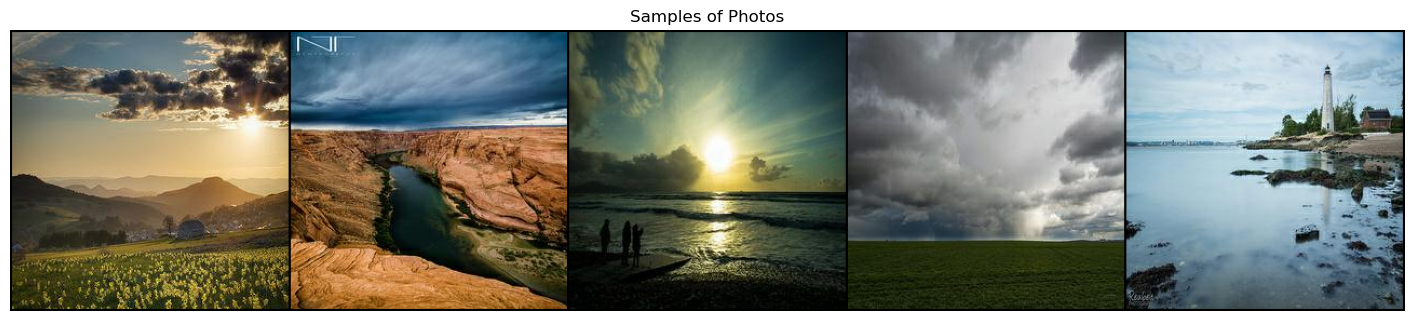

In [7]:
dm_sample = CustomDataModule(batch_size=5)
dm_sample.setup("fit")
dm_sample.setup("predict")

train_loader = dm_sample.train_dataloader()
monet_samples, _ = next(iter(train_loader))

predict_loader = dm_sample.predict_dataloader()
photo_samples = next(iter(predict_loader))

show_img(monet_samples, title="Samples of Monet Paintings")
show_img(photo_samples, title="Samples of Photos")

---

# 2. Building CycleGAN Architecture

### Generator.

<img src="https://lh5.googleusercontent.com/9kNO6hxYJmpcfG5bOjnDazieeLC7Q8jZJi3gTtnJelbkOUL7Xz9e-3F_SNuxPpo4fZ4=w2400" width="600"/>

_Example of the U-Net architecture [[source](https://paperswithcode.com/method/u-net)]._

We use a U-Net architecture for the CycleGAN generator. U-Net is a network which consists of downsampling blocks and upsampling blocks with skip connections, giving it the U-shaped architecture.

### Downsampling blocks.

The downsampling blocks use convolution layers to increase the number of feature maps while reducing the dimensions of the 2D image.

In [8]:
class Downsampling(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        norm=True,
        kernel_size=4,
        stride=2,
        padding=1,
    ):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,
                      stride=stride, padding=padding, bias=False)
        )
        if norm:
            self.block.append(nn.InstanceNorm2d(out_channels, affine=True))
        self.block.append(nn.LeakyReLU(0.3))
        
    def forward(self, x):
        return self.block(x)

### Upsampling blocks.

On the other hand, the upsampling blocks contain transposed convolution layers, which combine the learned features to output an image with the original size 256.

In [9]:
class Upsampling(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        dropout=False,
        kernel_size=4,
        stride=2,
        padding=1,
    ):
        super().__init__()
        self.block = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size,
                               stride=stride, padding=padding, bias=False),
            nn.InstanceNorm2d(out_channels, affine=True),
        )
        if dropout:
            self.block.append(nn.Dropout(0.5))
        self.block.append(nn.ReLU())
        
    def forward(self, x):
        return self.block(x)

### Building the generator.

With the building blocks defined, we can now build our CycleGAN generator. In the upsampling path, we concatenate the outputs of the upsampling blocks and the outputs of the downsampling blocks symmetrically. This can be seen as a kind of skip connection, facilitating information flow in deep networks and reducing the impact of vanishing gradients. For reference, the output size of each block is commented below.

In [10]:
class Generator(nn.Module):
    def __init__(self, in_channels, out_channels, hid_channels):
        super().__init__()
        self.downsampling_blocks = nn.Sequential(
            Downsampling(in_channels, hid_channels, norm=False), #64x128x128
            Downsampling(hid_channels, hid_channels*2), #128x64x64
            Downsampling(hid_channels*2, hid_channels*4), #256x32x32
            Downsampling(hid_channels*4, hid_channels*8), #512x16x16
            Downsampling(hid_channels*8, hid_channels*8), #512x8x8
            Downsampling(hid_channels*8, hid_channels*8), #512x4x4
            Downsampling(hid_channels*8, hid_channels*8), #512x2x2
            Downsampling(hid_channels*8, hid_channels*8, norm=False), #512x1x1
        )
        self.upsampling_blocks = nn.Sequential(
            Upsampling(hid_channels*8, hid_channels*8, dropout=True), #(512+512)x2x2
            Upsampling(hid_channels*16, hid_channels*8, dropout=True), #(512+512)x4x4
            Upsampling(hid_channels*16, hid_channels*8, dropout=True), #(512+512)x8x8
            Upsampling(hid_channels*16, hid_channels*8), #(512+512)x16x16
            Upsampling(hid_channels*16, hid_channels*4), #(256+256)x32x32
            Upsampling(hid_channels*8, hid_channels*2), #(128+128)x64x64
            Upsampling(hid_channels*4, hid_channels), #(64+64)x128x128
        )
        self.feature_block = nn.Sequential(
            nn.ConvTranspose2d(hid_channels*2, out_channels,
                               kernel_size=4, stride=2, padding=1), #3x256x256
            nn.Tanh(),
        )
        
    def forward(self, x):
        skips = []
        for down in self.downsampling_blocks:
            x = down(x)
            skips.append(x)
            
        skips = reversed(skips[:-1])
        for up, skip in zip(self.upsampling_blocks, skips):
            x = up(x)
            x = torch.cat([x, skip], dim=1)

        return self.feature_block(x)

### Discriminator.

<img src="https://lh6.googleusercontent.com/UhJiaTOQWgfHQlWq50IMGBvdkJ3NDggC449cxud8XVlSxUrule8f5LyoLUV8aaYemGw=w2400" width="300"/>

_Diagram of how the PatchGAN discriminator works [[source](https://www.researchgate.net/figure/PatchGAN-discriminator-Each-value-of-the-output-matrix-represents-the-probability-of_fig1_323904616)]._

Unlike conventional networks that output a single probability of the input image being real or fake, CycleGAN uses the PatchGAN discriminator that outputs a matrix of values. Intuitively, each value of the output matrix checks the corresponding portion of the input image. Values closer to 1 indicate real classification and values closer to 0 indicate fake classification.

### Building the discriminator.

In general, the PatchGAN discriminator consists of a sequence of convolution layers, which can be built using the downsampling blocks defined earlier. For reference, the output size of each block is commented below.

In [11]:
class Discriminator(nn.Module):
    def __init__(self, in_channels, hid_channels):
        super().__init__()
        self.block = nn.Sequential(
            Downsampling(in_channels, hid_channels, norm=False), #64x128x128
            Downsampling(hid_channels, hid_channels*2), #128x64x64
            Downsampling(hid_channels*2, hid_channels*4), #256x32x32
            Downsampling(hid_channels*4, hid_channels*8, stride=1), #512x31x31
            nn.Conv2d(hid_channels*8, 1, kernel_size=4, padding=1), #1x30x30
        )
        
    def forward(self, x):
        return self.block(x)

### Building the CycleGAN model.

With the generator and discriminator defined, we can now build CycleGAN, which consists of two generators and two discriminators:
* Generator for photo-to-Monet translation (`gen_PM`).
* Generator for Monet-to-photo translation (`gen_MP`).
* Discriminator for Monet paintings (`disc_M`).
* Discriminator for photos (`disc_P`).

Using the `weights_init` function, the weights of the layers in the generators and discriminators are initialized using the normal distribution and the biases are initialized to 0s. The Adam optimizer is used for model training. To optimize these parameters, we need to define the loss functions:
* **Discriminator loss** (`disc_loss`). For real images fed into the discriminator, the output matrix is compared against a matrix of 1s using the binary cross-entropy. For fake images, the output matrix is compared against a matrix of 0s. This suggests that to minimize loss, the perfect discriminator outputs a matrix of 1s for real images and a matrix of 0s for fake images.
* **Generator loss** (`gen_loss`). This is composed of three different loss functions below.
  * *Adversarial loss* (`adv_loss`). Fake images are fed into the discriminator and the output matrix is compared against a matrix of 1s using the binary cross-entropy. To minimize loss, the generator needs to 'fool' the discriminator into thinking that the fake images are real and output a matrix of 1s.
  * *Identity loss* (`id_loss`). When a Monet painting is fed into the photo-to-Monet generator, we should get back the same Monet painting because nothing needs to be transformed. The same applies for photos fed into the Monet-to-photo generator. To encourage identity mapping, the difference in pixel values between the input image and generated image is measured using the l1 loss.
  * *Cycle loss* (`cycle_loss`). When a Monet painting is fed into the Monet-to-photo generator, and the generated image is fed back into the photo-to-Monet generator, it should transform back into the original Monet painting. The same applies for photos passed to the two generators to get back the original photo. To preserve information throughout this cycle, the l1 loss is used to measure the difference between the original image and the cycled image.

From the above, the binary cross-entropy and the l1 loss are defined as the adversarial criterion (`adv_criterion`) and the reconstruction criterion (`recon_criterion`) respectively. To organize the code for modeling, we define the above functions within the `pl.LightningModule` class together with the following methods:
* `__init__` to initialize the two generators, the two discriminators, and other parameters.
* `forward` to generate Monet-style images given input photos.
* `configure_optimizers` to define the Adam optimizers.
* `training_step` to compute the loss functions for the generators and discriminators.
* `training_epoch_end` to print the average values of the loss functions over the batches per epoch, and visualize the performance of `gen_PM`.
* `predict_step` to run the `forward` method during prediction.

Other useful methods can be found [here](https://pytorch-lightning.readthedocs.io/en/stable/common/lightning_module.html). The following parameters are set:
* `IN_CHANNELS` — the number of input channels for the generator and discriminator, which equals 3 since we are working with RGB images.
* `OUT_CHANNELS` — the number of output channels for the generator, which equals 3 as we are trying to output a RGB image.
* `HID_CHANNELS` — the number of output channels in the first layer for the generator and discriminator.
* `LR` and `BETAS` — the learning rate and beta parameters for the Adam optimizer.
* `LAMBDA` — the weight used in the identity loss and cycle loss.
* `NUM_EPOCHS` — the number of epochs for model training.
* `DISPLAY_EPOCHS` — the frequency to display the training progress described in `training_epoch_end`.

In [12]:
IN_CHANNELS = 3
OUT_CHANNELS = 3
HID_CHANNELS = 64
LR = 2e-4
BETAS = (0.5, 0.999)
LAMBDA = 10
NUM_EPOCHS = 180
DISPLAY_EPOCHS = 30

In [13]:
class CycleGAN(pl.LightningModule):
    def __init__(
        self, 
        in_channels=IN_CHANNELS,
        out_channels=OUT_CHANNELS, 
        hid_channels=HID_CHANNELS,
        lr=LR,
        betas=BETAS,
        lambda_w=LAMBDA,
        display_epochs=DISPLAY_EPOCHS,
        photo_samples=photo_samples,
    ):
        super().__init__()
        self.lr = lr
        self.betas = betas
        self.lambda_w = lambda_w
        self.display_epochs = display_epochs
        self.photo_samples = photo_samples
        self.loss_history = []
        self.epoch_count = 0
        
        self.gen_PM = Generator(in_channels, out_channels, hid_channels).apply(self.weights_init)
        self.gen_MP = Generator(in_channels, out_channels, hid_channels).apply(self.weights_init)
        self.disc_M = Discriminator(in_channels, hid_channels).apply(self.weights_init)
        self.disc_P = Discriminator(in_channels, hid_channels).apply(self.weights_init)
        
    def forward(self, z):
        return self.gen_PM(z)
    
    def weights_init(self, m):
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.InstanceNorm2d)):
            nn.init.normal_(m.weight, 0., 0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0.)
    
    def adv_criterion(self, y_hat, y):
        return F.binary_cross_entropy_with_logits(y_hat, y)
    
    def recon_criterion(self, y_hat, y):
        return F.l1_loss(y_hat, y)
    
    def adv_loss(self, real_X, disc_Y, gen_XY):
        fake_Y = gen_XY(real_X)
        disc_fake_Y_hat = disc_Y(fake_Y)
        adv_loss_XY = self.adv_criterion(disc_fake_Y_hat, torch.ones_like(disc_fake_Y_hat))
        return adv_loss_XY, fake_Y
    
    def id_loss(self, real_X, gen_YX):
        id_X = gen_YX(real_X)
        id_loss_X = self.recon_criterion(id_X, real_X)
        return id_loss_X
    
    def cycle_loss(self, real_X, fake_Y, gen_YX):
        cycle_X = gen_YX(fake_Y)
        cycle_loss_X = self.recon_criterion(cycle_X, real_X)
        return cycle_loss_X
        
    def gen_loss(self, real_X, real_Y, gen_XY, gen_YX, disc_Y):
        adv_loss_XY, fake_Y = self.adv_loss(real_X, disc_Y, gen_XY)

        id_loss_Y = self.id_loss(real_Y, gen_XY)
        
        cycle_loss_X = self.cycle_loss(real_X, fake_Y, gen_YX)
        cycle_loss_Y = self.cycle_loss(real_Y, gen_YX(real_Y), gen_XY)
        cycle_loss = cycle_loss_X + cycle_loss_Y
        
        gen_loss_XY = adv_loss_XY + 0.5*self.lambda_w*id_loss_Y + self.lambda_w*cycle_loss
        return gen_loss_XY
    
    def disc_loss(self, real_X, fake_X, disc_X):
        disc_fake_hat = disc_X(fake_X.detach())
        disc_fake_loss = self.adv_criterion(disc_fake_hat, torch.zeros_like(disc_fake_hat))
        
        disc_real_hat = disc_X(real_X)
        disc_real_loss = self.adv_criterion(disc_real_hat, torch.ones_like(disc_real_hat))
        
        disc_loss = (disc_fake_loss+disc_real_loss) / 2
        return disc_loss
    
    def configure_optimizers(self):
        params = {
            "lr": self.lr,
            "betas": self.betas,
        }
        opt_gen_PM = torch.optim.Adam(self.gen_PM.parameters(), **params)
        opt_gen_MP = torch.optim.Adam(self.gen_MP.parameters(), **params)
        
        opt_disc_M = torch.optim.Adam(self.disc_M.parameters(), **params)
        opt_disc_P = torch.optim.Adam(self.disc_P.parameters(), **params)
        
        return [opt_gen_PM, opt_gen_MP, opt_disc_M, opt_disc_P], []
    
    def training_step(self, batch, batch_idx, optimizer_idx):
        real_M, real_P = batch
        if optimizer_idx == 0:
            gen_loss_PM = self.gen_loss(real_P, real_M, self.gen_PM, self.gen_MP, self.disc_M)
            return gen_loss_PM
        if optimizer_idx == 1:
            gen_loss_MP = self.gen_loss(real_M, real_P, self.gen_MP, self.gen_PM, self.disc_P)
            return gen_loss_MP
        
        if optimizer_idx == 2:
            disc_loss_M = self.disc_loss(real_M, self.gen_PM(real_P), self.disc_M)
            return disc_loss_M
        if optimizer_idx == 3:
            disc_loss_P = self.disc_loss(real_P, self.gen_MP(real_M), self.disc_P)
            return disc_loss_P
    
    def training_epoch_end(self, outputs):
        self.epoch_count += 1
        
        losses = []
        for j in range(4):
            loss = np.mean([out[j]["loss"].item() for out in outputs])
            losses.append(loss)
        self.loss_history.append(losses)
        
        if self.epoch_count%10 == 0:
            print(
                f"Epoch {self.epoch_count} -",
                f"gen_loss_PM: {losses[0]:.5f} -",
                f"gen_loss_MP: {losses[1]:.5f} -",
                f"disc_loss_M: {losses[2]:.5f} -",
                f"disc_loss_P: {losses[3]:.5f}",
            )
        
        if self.epoch_count%self.display_epochs==0 or self.epoch_count==1:
            gen_monets = self(self.photo_samples.to(self.device)).detach().cpu()
            show_img(
                torch.cat([self.photo_samples, gen_monets]),
                nrow=5,
                title=f"Epoch {self.epoch_count}: Photo-to-Monet Translation",
            )
            
    def predict_step(self, batch, batch_idx):
        return self(batch)
    
    def loss_curves(self):
        labels = ["gen_loss_PM", "gen_loss_MP", "disc_loss_M", "disc_loss_P"]
        titles = ["Generator Loss Curves", "Discriminator Loss Curves"]
        num_epochs = len(self.loss_history)
        plt.figure(figsize=(18, 4.5))
        for j in range(4):
            if j%2 == 0:
                plt.subplot(1, 2, (j//2)+1)
                plt.title(titles[j//2])
                plt.ylabel("Loss")
                plt.xlabel("Epoch")
            plt.plot(
                np.arange(1, num_epochs+1),
                [losses[j] for losses in self.loss_history],
                label=labels[j],
            )
            plt.legend(loc="upper right")

---

# 3. Training Model

To start training the model, we use `pl.Trainer` to automatically handle the training loop by running the `fit` method.

In [ ]:
trainer = pl.Trainer(
    accelerator="gpu",
    devices=1,
    logger=False,
    enable_checkpointing=False,
    max_epochs=NUM_EPOCHS,
)

dm = CustomDataModule()
model = CycleGAN()
trainer.fit(model, datamodule=dm)

### Plotting the loss curves.

To examine the loss curves of the generators and discriminators, we record the losses in `training_epoch_end` and define an additional method `loss_curves` above to plot the curves.

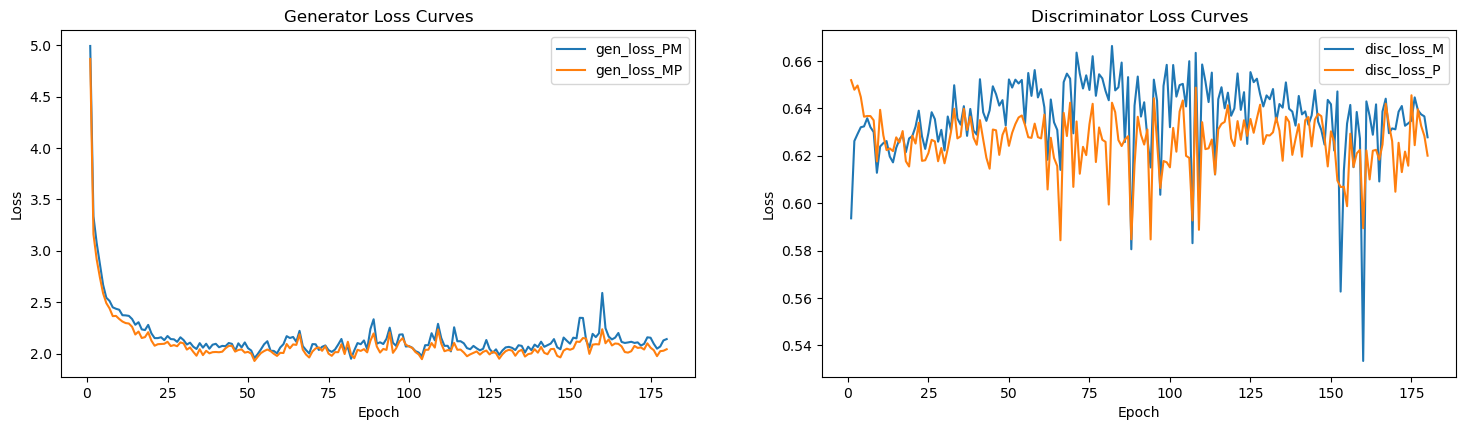

In [15]:
model.loss_curves()

---

# 4. Submission

Computing the predictions can be done by running the `predict` method to generate the Monet-style images given the input photos.

In [16]:
predictions = trainer.predict(model, datamodule=dm)

Predicting: 300it [00:00, ?it/s]

### Saving the generated images.

In [17]:
os.makedirs("../images", exist_ok=True)

idx = 0
for tensor in predictions:
    for monet in tensor:
        save_image((monet.squeeze()*0.5+0.5), fp=f"../images/{idx}.jpg")
        idx += 1

shutil.make_archive("/kaggle/working/images", "zip", "/kaggle/images")

'/kaggle/working/images.zip'

---